#**Importing Libraries and Reading the Dataset**

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

In [30]:
hd=pd.read_csv('/content/heart_preinc_scal.csv')
hd.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


**Dropping the 'target' column**

In [31]:
target = hd['target']
X = hd.drop("target", axis=1)  # keep only features

#**Scaling and Encoding**

In [32]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

In [33]:
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Apply preprocessing on the entire dataset
X_final = preprocessor.fit_transform(X)
print("Final dataset shape:", X_final.shape)

Final dataset shape: (298, 13)


# **K-Means Clustering**

**Elbow Method to Determine K**

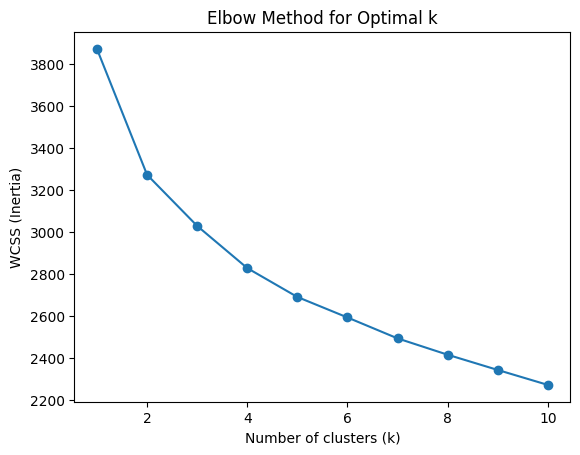

In [34]:
wcss = []
K = range(1, 11)  # test k from 1 to 10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_final)
    wcss.append(kmeans.inertia_)

# Plot elbow
plt.plot(K, wcss, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [35]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_final)

# Cluster labels
labels = kmeans.labels_

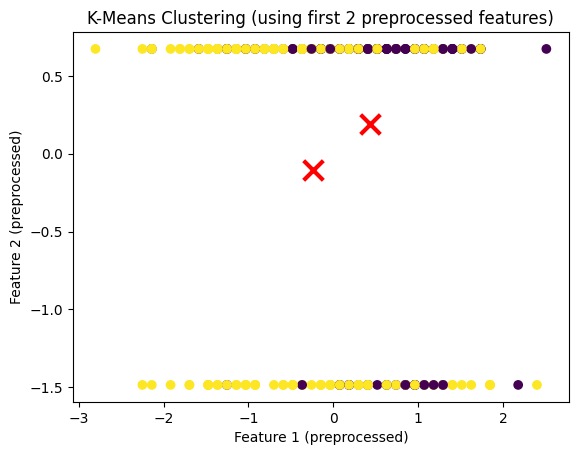

In [36]:
plt.scatter(X_final[:, 0], X_final[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='x', s=200, linewidths=3, color='r')
plt.title("K-Means Clustering (using first 2 preprocessed features)")
plt.xlabel("Feature 1 (preprocessed)")
plt.ylabel("Feature 2 (preprocessed)")
plt.show()

In [37]:
score = silhouette_score(X_final, kmeans.labels_)
print("Silhouette Score:", score)

Silhouette Score: 0.16692934032341614


#**Hierarchical Clustering (Dendrogram Analysis)**

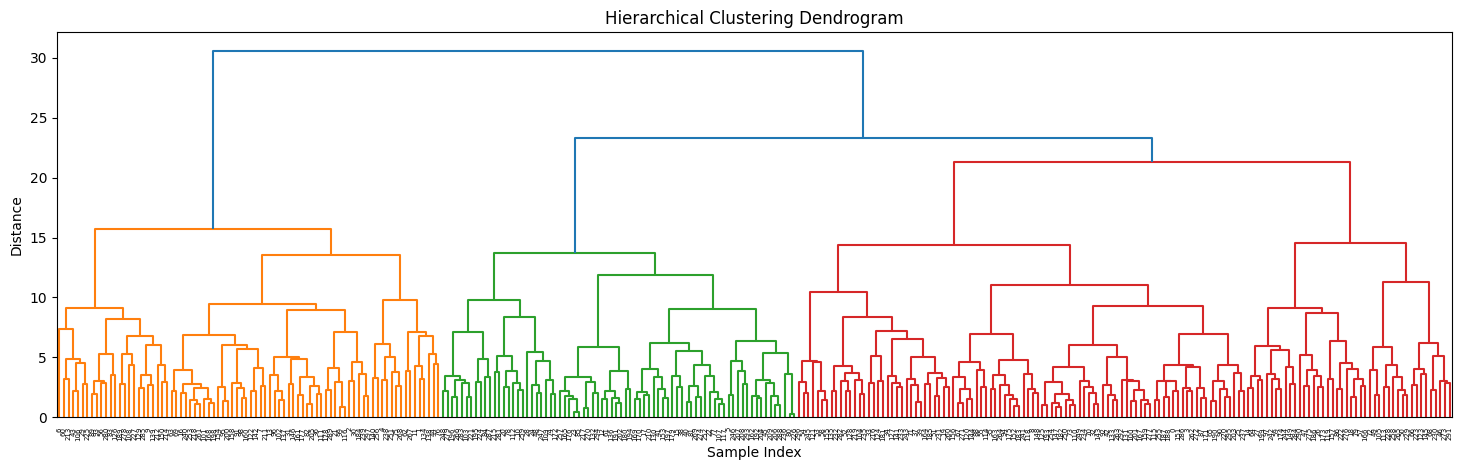

In [38]:
linked = linkage(X_final.toarray() if hasattr(X_final, "toarray") else X_final, method='ward')

plt.figure(figsize=(18, 5))
dendrogram(linked)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

**Fit Agglomerative Clustering**

In [43]:
hc = AgglomerativeClustering(n_clusters=2, linkage="ward")
hc_labels = hc.fit_predict(X_final.toarray() if hasattr(X_final, "toarray") else X_final)

print("Cluster labels (first 10):", hc_labels[:10])

Cluster labels (first 10): [0 1 1 0 1 0 1 1 0 1]


# **Comparing Clusters With Actual Disease Labels**

**K-Means Evaluation**

In [45]:
ari_kmeans = adjusted_rand_score(target, kmeans.labels_)
print("Adjusted Rand Index (ARI):", ari_kmeans)


-----KMeans Evaluation------
Adjusted Rand Index (ARI): 0.4129556900522755


In [46]:
print("Homogeneity:", homogeneity_score(target, kmeans.labels_))
print("Completeness:", completeness_score(target, kmeans.labels_))
print("V-Measure:", v_measure_score(target, kmeans.labels_))

Homogeneity: 0.33362613898847476
Completeness: 0.35225784476350774
V-Measure: 0.3426889312503527


In [47]:
cm_kmeans = confusion_matrix(target, kmeans.labels_)
cm_kmeans_df = pd.DataFrame(cm_kmeans,
                     index=[f"True {i}" for i in sorted(set(target))],
                     columns=[f"Cluster {i}" for i in sorted(set(kmeans.labels_))])
print("\nConfusion Matrix (KMeans):\n", cm_kmeans_df)


Confusion Matrix (KMeans):
         Cluster 0  Cluster 1
True 0         95         41
True 1         12        150


**Hierarchical Evaluation**

In [48]:
print("\nHierarchical Clustering Evaluation")
ari_hc = adjusted_rand_score(target, hc_labels)
print("Adjusted Rand Index (ARI):", ari_hc)


Hierarchical Clustering Evaluation
Adjusted Rand Index (ARI): 0.2639650595323255


In [50]:
print("Homogeneity:", homogeneity_score(target, hc_labels))
print("Completeness:", completeness_score(target, hc_labels))
print("V-Measure:", v_measure_score(target, hc_labels))

Homogeneity: 0.227162043289505
Completeness: 0.26616126792879585
V-Measure: 0.24512013153368176


In [49]:
cm_hc = confusion_matrix(target, hc_labels)
cm_hc_df = pd.DataFrame(cm_hc,
                     index=[f"True {i}" for i in sorted(set(target))],
                     columns=[f"Cluster {i}" for i in sorted(set(hc_labels))])
print("\nConfusion Matrix (Hierarchical):\n", cm_hc_df)


Confusion Matrix (Hierarchical):
         Cluster 0  Cluster 1
True 0         63         73
True 1        153          9
